<a href="https://colab.research.google.com/github/akfangus/MLproject/blob/main/%EC%A3%BC%ED%83%9D%EA%B0%80%EA%B2%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=c371924b9216aa4a08adb809f81893a7adbb8f65bf75c261f29706bfa40feb7a
  Stored in directory: c:\users\sh.lee\appdata\local\pip\cache\wheels\ac\b2\c3\fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle


In [ ]:
!kaggle competitions list

ref                                                  deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                         2030-07-01 23:59:00  Getting Started     Prizes         64           False  
gan-getting-started                                  2030-07-01 23:59:00  Getting Started     Prizes        148           False  
tpu-getting-started                                  2030-06-03 23:59:00  Getting Started  Knowledge        205           False  
digit-recognizer                                     2030-01-01 00:00:00  Getting Started  Knowledge       1574            True  
titanic                                              2030-01-01 00:00:00  Getting Started  Knowledge      50183            True  
house-prices-advanced-regression-techniques          2030-01-01 00:00:00  Getting Started 

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques


  0%|          | 0.00/199k [00:00<?, ?B/s]
100%|##########| 199k/199k [00:00<00:00, 11.0MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import norm, skew


style.use('seaborn-talk')

krfont={'family':'Malgun Gothic', 'weight': 'bold', 'size' : 10}
matplotlib.rc('font', **krfont)
matplotlib.rcParams['axes.unicode_minus'] = False

%matplotlib inline


In [ ]:
train = pd.read_csv('house-price/train.csv')
test = pd.read_csv('house-price/test.csv')

In [ ]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [ ]:
# 편향성을 드러낼 가능성이 있는 데이터를 '삭제'
train.drop(train[(train['OverallQual']<4) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['OverallCond']<4) & (train['SalePrice']>200000)].index, inplace=True)

train.reset_index(drop=True, inplace=True)

In [ ]:
train.shape

(1458, 81)

## 타겟변수(종속변수)의 분포 확인 및 변환

In [ ]:
(mu, sigma) = norm.fit(train['SalePrice'])
mu,sigma

(180761.24142661178, 79270.93617295024)

<ipython-input-16-13cfc731c610>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


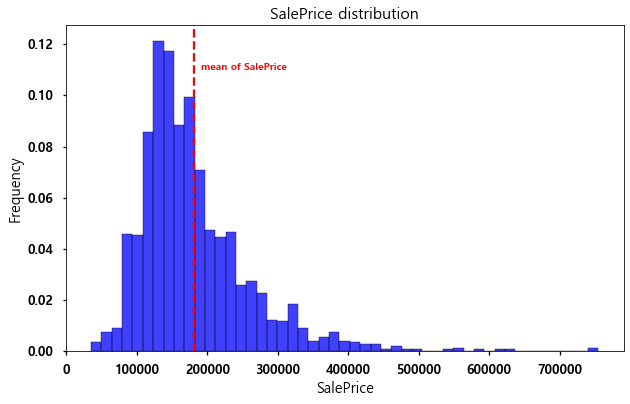

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(train['SalePrice'], color='b', stat = 'probability')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')

plt.axvline(mu, color='r', linestyle='--')
plt.text(mu+10000, 0.11, 'mean of SalePrice', rotation=0, color='r')
fig.show()




## 타겟변수가 정규분포를 이루지않음
- 선형회귀는 정규분포를 만족해야함
- log를 취해서 스케일 진행

In [ ]:
train['SalePrice'] = np.log1p(train['SalePrice'])

In [ ]:
(mu, sigma) = norm.fit(train['SalePrice'])
mu,sigma

(12.0233397799989, 0.3989191793099824)

<ipython-input-19-8f6db4cbe5be>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


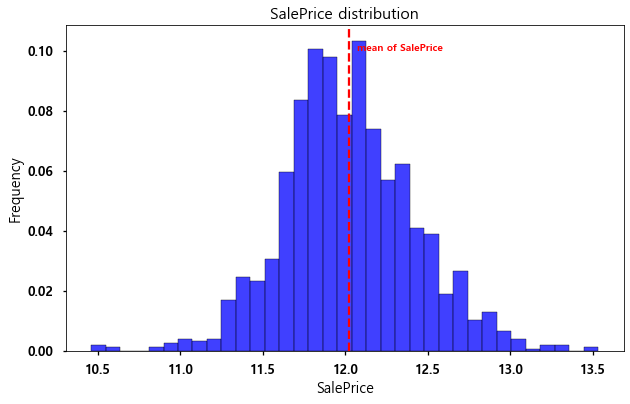

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(train['SalePrice'], color='b', stat = 'probability')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')

plt.axvline(mu, color='r', linestyle='--')
plt.text(mu+0.05, 0.10, 'mean of SalePrice', rotation=0, color='r')
fig.show()




- 데이터에 log를 취하니까 정규분포 형태로 변화한것을 볼 수 있다.

# 데이터 합치기

- 입력변수로 사용할 Id는 별도객체 저장하고 삭제

In [ ]:
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape

((1458, 80), (1459, 79))

- 훈련데이터에 있는 SalePRice 변수를 별도로 추출해 저장한 후 훈련 데이터에서 삭제

In [ ]:
y = train['SalePrice'].reset_index(drop=True)
train = train.drop('SalePrice', axis=1)
train.shape, test.shape, y.shape

((1458, 79), (1459, 79), (1458,))

- 타겟 빼니깐 train과 test가 변수가 동일하므로 합쳐서 전처리하겟음

In [ ]:
all_df = pd.concat([train,test]).reset_index(drop=True)
all_df.shape

(2917, 79)

# 결측치 처리
- 결측치를 확인해 비율로 계산한 뒤 내림차순으로 정렬
- head_num=6은 결측치가 존재하면 최소 6개 출력

In [ ]:
def check_na(data, head_num=6):
    isnull_na = (data.isnull().sum()/len(data))*100
    data_na = isnull_na.drop(isnull_na[isnull_na==0].index).sort_values(ascending=False)
    
    missing_data = pd.DataFrame({
        'Missing Ratio' : data_na,
        'Data Type' : data.dtypes[data_na.index]
    })
    print('결측치 데이터 갈럼과 건수 : \n', missing_data.head(head_num))

In [ ]:
check_na(all_df, 20)

결측치 데이터 갈럼과 건수 : 
               Missing Ratio Data Type
PoolQC            99.657182    object
MiscFeature       96.400411    object
Alley             93.212204    object
Fence             80.425094    object
FireplaceQu       48.680151    object
LotFrontage       16.626671   float64
GarageFinish       5.450806    object
GarageQual         5.450806    object
GarageCond         5.450806    object
GarageYrBlt        5.450806   float64
GarageType         5.382242    object
BsmtExposure       2.811107    object
BsmtCond           2.811107    object
BsmtQual           2.776826    object
BsmtFinType2       2.742544    object
BsmtFinType1       2.708262    object
MasVnrType         0.788481    object
MasVnrArea         0.754200   float64
MSZoning           0.137127    object
BsmtFullBath       0.068564   float64


- 결측치 처리는 처리하는 기준이 데이터마다 매우 다르기때문에 
- 분석중에 어려운 부분
- 위 데이터에서는 결측치가 전체데이터의 10%가 넘어가는 상위6개를 삭제

In [ ]:
all_df.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage'], axis=1, inplace=True)


KeyError: "['PoolQC' 'MiscFeature' 'Alley' 'Fence' 'FireplaceQu' 'LotFrontage'] not found in axis"

- 남은 데이터의 결측치는 fillna()함수를 통해 특정 값으로 채워넣도록 한다
- 여기서는 문자열 데이터는 빈도수중 가장 높은값, 수치데이터는 중앙값(median)으로 채움

In [ ]:
check_na(all_df, 30)

결측치 데이터 갈럼과 건수 : 
               Missing Ratio Data Type
GarageCond         5.450806    object
GarageQual         5.450806    object
GarageYrBlt        5.450806   float64
GarageFinish       5.450806    object
GarageType         5.382242    object
BsmtCond           2.811107    object
BsmtExposure       2.811107    object
BsmtQual           2.776826    object
BsmtFinType2       2.742544    object
BsmtFinType1       2.708262    object
MasVnrType         0.788481    object
MasVnrArea         0.754200   float64
MSZoning           0.137127    object
Functional         0.068564    object
Utilities          0.068564    object
BsmtFullBath       0.068564   float64
BsmtHalfBath       0.068564   float64
GarageArea         0.034282   float64
GarageCars         0.034282   float64
TotalBsmtSF        0.034282   float64
KitchenQual        0.034282    object
Electrical         0.034282    object
BsmtUnfSF          0.034282   float64
BsmtFinSF2         0.034282   float64
BsmtFinSF1         0.034282   f

### 결측치 - 문자열 데이터

In [ ]:
temp = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage']

In [ ]:
cat_all_vars = train.select_dtypes(exclude=[np.number])
print('Whole number of all_vars : ',len(list(cat_all_vars)))


final_cat_vars=[]

for v in cat_all_vars:
    if v not in temp:
        final_cat_vars.append(v)
        
print('Whole number of final_cat_vars : ',len(list(final_cat_vars)))


for i in final_cat_vars:
    all_df[i]=all_df[i].fillna(all_df[i].mode()[0])

Whole number of all_vars :  43
Whole number of final_cat_vars :  38


In [ ]:
all_df.isna().sum().sort_values(ascending=False)

GarageYrBlt      159
MasVnrArea        22
BsmtHalfBath       2
BsmtFullBath       2
TotalBsmtSF        1
                ... 
BsmtExposure       0
BsmtFinType1       0
BsmtFinType2       0
MSZoning           0
SaleCondition      0
Length: 73, dtype: int64

- 문자열 데이터는 mode()함수를 이용해 최빈값으로 fillna해준모습
- 확인해보니 수치형데이터를 제외하고는 결측치가 채워진 모습이다...

In [ ]:
check_na(all_df,20)

결측치 데이터 갈럼과 건수 : 
               Missing Ratio Data Type
GarageYrBlt        5.450806   float64
MasVnrArea         0.754200   float64
BsmtFullBath       0.068564   float64
BsmtHalfBath       0.068564   float64
BsmtFinSF1         0.034282   float64
BsmtFinSF2         0.034282   float64
BsmtUnfSF          0.034282   float64
TotalBsmtSF        0.034282   float64
GarageCars         0.034282   float64
GarageArea         0.034282   float64


### 결측치 - 수치형 데이터

In [ ]:
num_all_vars = list(train.select_dtypes(include=[np.number]))
print('Whole number of all_vars : ',len(list(num_all_vars)))
num_all_vars.remove('LotFrontage')

# final_cat_vars=[]

# for v in num_all_vars:
#     if v not in temp:
#         final_cat_vars.append(v)
        
# print('Whole number of final_cat_vars : ',len(list(final_cat_vars)))


for i in num_all_vars:
    all_df[i].fillna(value=all_df[i].median(), inplace=True)

Whole number of all_vars :  36


In [ ]:
check_na(all_df,20)

결측치 데이터 갈럼과 건수 : 
 Empty DataFrame
Columns: [Missing Ratio, Data Type]
Index: []


- 결측치가 모두 처리되었당.

# 왜도(skewness) 값 처리
- 분포의 비대칭도를 나타내는 통계량
- 정규분포는 왜도가 0
- 수치형 데이터에 적용
- 정규분포의 형태를 형성하는것이 중요

In [ ]:
def find_skew(x):
    return skew(x)
skew_features = all_df[num_all_vars].apply(find_skew).sort_values(ascending = False)
skew_features

MiscVal          21.939672
PoolArea         16.892477
LotArea          12.867139
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.318923
BsmtFinSF2        4.144503
EnclosedPorch     4.013741
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.615714
OpenPorchSF       2.534326
WoodDeckSF        1.841876
1stFlrSF          1.469798
BsmtFinSF1        1.429239
MSSubClass        1.374726
GrLivArea         1.271773
TotalBsmtSF       1.165468
BsmtUnfSF         0.919795
2ndFlrSF          0.860643
TotRmsAbvGrd      0.760404
Fireplaces        0.734449
HalfBath          0.695072
BsmtFullBath      0.626733
OverallCond       0.584601
BedroomAbvGr      0.329555
GarageArea        0.241611
OverallQual       0.196514
MoSold            0.195229
FullBath          0.164226
YrSold            0.132129
GarageCars       -0.218309
GarageYrBlt      -0.398311
YearRemodAdd     -0.451063
YearBuilt        -0.600023
dtype: float64

- LotArea 컬럼은 값이 매우커서 수치비교 시각화할때 제외함

In [ ]:
skewnewss_index = list(skew_features.index)
skewnewss_index.remove('LotArea')
all_numeric_df = all_df.loc[:,skewnewss_index]


[Text(0.5, 1.0, 'Numeric Distribution of Features Before Box-cox Transformation')]

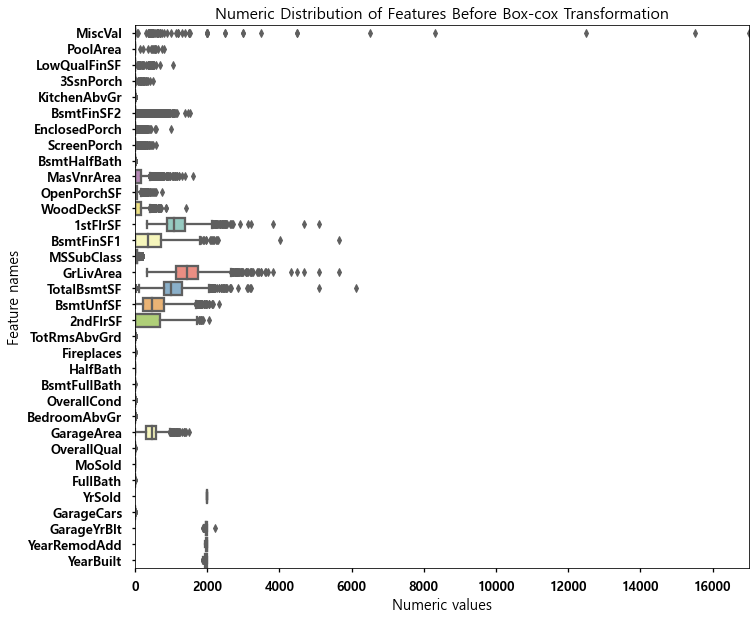

In [ ]:
fig, ax = plt.subplots(figsize=(11,10))
ax.set_xlim(0, all_numeric_df.max().sort_values(ascending=False)[0])
ax = sns.boxplot(data = all_numeric_df[skewnewss_index], orient='h', palette='Set3')
ax.xaxis.grid(False)
ax.set(ylabel='Feature names')
ax.set(xlabel='Numeric values')
ax.set(title='Numeric Distribution of Features Before Box-cox Transformation')

- 왜도가 높을수록 Box가 잘 안나타남. ==> 오른쪽으로 치우친 데이터를 많이 확인할 수 있음.
- 이걸 그대로 모델에 돌리면 왜곡된 값이 나올 수 있음
- Box-Cox Tranformation 으로 전처리

In [ ]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [ ]:
high_skew = skew_features[skew_features>1]
high_skew_index = high_skew.index
print('변경전 : \n', all_df[high_skew_index].head())

for num_var in high_skew_index:
    all_df[num_var] = boxcox1p(all_df[num_var], boxcox_normmax(all_df[num_var]+1))
    
print('변경후 : \n', all_df[high_skew_index].head())

변경전 : 
    MiscVal  PoolArea  LotArea  LowQualFinSF  3SsnPorch  KitchenAbvGr  \
0        0         0     8450             0          0             1   
1        0         0     9600             0          0             1   
2        0         0    11250             0          0             1   
3        0         0     9550             0          0             1   
4        0         0    14260             0          0             1   

   BsmtFinSF2  EnclosedPorch  ScreenPorch  BsmtHalfBath  MasVnrArea  \
0         0.0              0            0           0.0       196.0   
1         0.0              0            0           1.0         0.0   
2         0.0              0            0           0.0       162.0   
3         0.0            272            0           0.0         0.0   
4         0.0              0            0           0.0       350.0   

   OpenPorchSF  WoodDeckSF  1stFlrSF  BsmtFinSF1  MSSubClass  GrLivArea  \
0           61           0       856       706.0         

C:\Users\sh.lee\anaconda3\envs\test\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\sh.lee\anaconda3\envs\test\lib\site-packages\scipy\stats\stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


# 도출 변수 생성
- 주어진 변수내에서 새로운 변수를 도출하는 과정
- ex)날짜 데이터 => 연도, 월, 일, 시간 등으로 쪼개기
- 여러개의 변수를 조합해 하나의 변수로 줄임(PCA 와 같은 방법)


### 주택데이터 도출변수
- 주택 각각의 크기인 TotalBsmtSF, 1stFlrSF, 2ndFlrSf를 합쳐 전체주택크기(TotalSF)를 만든다


In [ ]:
all_df['Total_Bathrooms'] = (all_df['FullBath'] + (0.5*all_df['HalfBath']) + all_df['BsmtFullBath'] + (0.5*all_df['BsmtHalfBath']))

all_df['Total_porch_sf'] = (all_df['OpenPorchSF']  + all_df['3SsnPorch'] + all_df['EnclosedPorch'] + all_df['ScreenPorch'])

all_df = all_df.drop(['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','OpenPorchSF','EnclosedPorch','ScreenPorch','3SsnPorch'], axis=1)



In [ ]:
all_df.shape

(2917, 67)

- 연도와 관련있는 데이터 처리
1. 변수 추출

In [ ]:
# 문자열에 해당 단어가 들어가는지 안들어가는지 판단하는 건데 이게되네?
num_all_vars = list(train.select_dtypes(include=[np.number]))
year_feature=[]

for var in num_all_vars:
    if 'Yr' in var:
        year_feature.append(var)
    elif 'Year' in var:
        year_feature.append(var)
    else:
        print(var,' is not related with Year')
        
print(year_feature)

MSSubClass  is not related with Year
LotFrontage  is not related with Year
LotArea  is not related with Year
OverallQual  is not related with Year
OverallCond  is not related with Year
MasVnrArea  is not related with Year
BsmtFinSF1  is not related with Year
BsmtFinSF2  is not related with Year
BsmtUnfSF  is not related with Year
TotalBsmtSF  is not related with Year
1stFlrSF  is not related with Year
2ndFlrSF  is not related with Year
LowQualFinSF  is not related with Year
GrLivArea  is not related with Year
BsmtFullBath  is not related with Year
BsmtHalfBath  is not related with Year
FullBath  is not related with Year
HalfBath  is not related with Year
BedroomAbvGr  is not related with Year
KitchenAbvGr  is not related with Year
TotRmsAbvGrd  is not related with Year
Fireplaces  is not related with Year
GarageCars  is not related with Year
GarageArea  is not related with Year
WoodDeckSF  is not related with Year
OpenPorchSF  is not related with Year
EnclosedPorch  is not related with

- SalePrice와 연관지어서 시각화

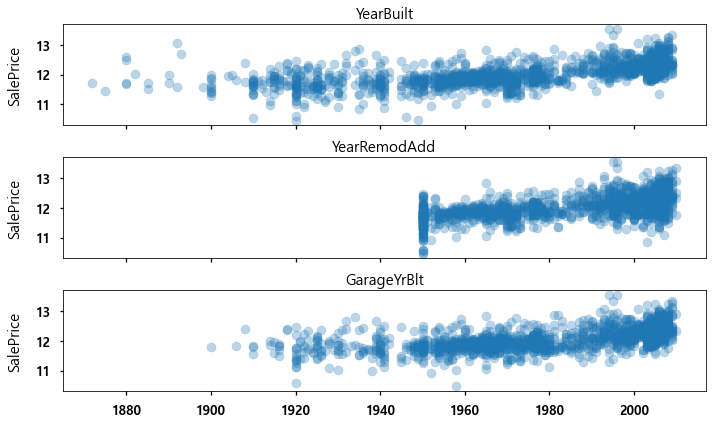

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(10,6), sharex=True, sharey=True)
for i, var in enumerate(year_feature):
    if var != 'YrSold':
        ax[i].scatter(train[var], y, alpha=0.3)
        ax[i].set_title('{}'.format(var), size=15)
        ax[i].set_ylabel('SalePrice', size=15, labelpad=12.5)
        
        
plt.tight_layout()
plt.show()

- 약소하지만 우상향 그래프의 추세를 확인할 수 있음.
- 리모델링만 기준삼고 나머지는 삭제

In [ ]:
all_df = all_df.drop(['YearBuilt','GarageYrBlt'], axis=1)
all_df.shape

(2917, 65)

- YrSolr와 YearRemodAdd 연도차이 값에 대한 변수 Years SinceRemodel 을 만들어 SalePrice와 시각화

<ipython-input-72-9c5bb38c3e61>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


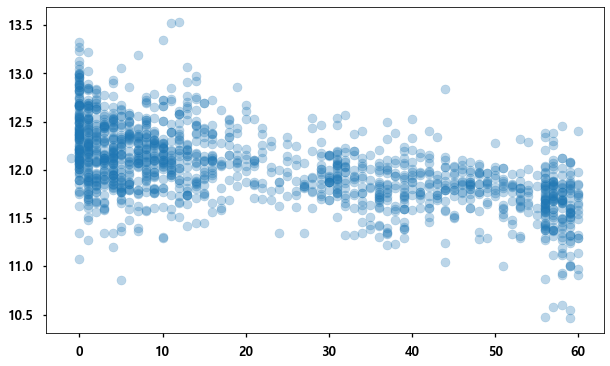

In [ ]:
YearsSinceRemodel= train['YrSold'].astype(int) - train['YearRemodAdd'].astype(int)

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(YearsSinceRemodel, y, alpha=0.3)
fig.show()

- 이건 하향 그래프를 보이넹
- 이제 전체데이터에 차이값을 저장하고 해당 계산했던 두개 변수는 삭제

In [ ]:
all_df['YearsSinceRemodel'] = all_df['YrSold'].astype(int) - all_df['YearRemodAdd'].astype(int)

all_df = all_df.drop(['YrSold','YearRemodAdd'],axis=1)
print(all_df.shape)

(2917, 64)


# 더미 변수의 응용
- 범주형을 수치형으로 바꾸는 방법


In [ ]:
all_df['PoolArea'].value_counts()

0.000000    2904
5.786592       1
5.854880       1
5.913422       1
4.721829       1
5.718339       1
5.130822       1
6.231253       1
5.843017       1
6.048367       1
5.922802       1
6.161331       1
5.945810       1
5.553562       1
Name: PoolArea, dtype: int64

- Poolarea같은 경우는 0값이 압도적으로 많고 나머지 변수들은 적당히 분포
- 그냥 제거하는것도 방법이 될수 있고
- 1이상은 1로 처리해서 0,1 두개의 값만 가질수 있게 하는것도 하나의 방법이 될 수 있다( 정답은 없음)


In [ ]:
def count_dummy(x):
    if x>0:
        return 1
    else:
        return 0
    
all_df['PoolArea'] = all_df['PoolArea'].apply(count_dummy)
all_df['PoolArea'].value_counts()

0    2904
1      13
Name: PoolArea, dtype: int64

- GarageArea , Fireplaces 변수도 보고 똑같이 적용해보자
- 일단 하라는대로 하자

In [ ]:
all_df['GarageArea'].value_counts()

0.0       157
576.0      97
440.0      96
240.0      69
484.0      67
         ... 
1110.0      1
766.0       1
208.0       1
1043.0      1
428.0       1
Name: GarageArea, Length: 603, dtype: int64

In [ ]:
all_df['GarageArea'] = all_df['GarageArea'].apply(count_dummy)
all_df['GarageArea'].value_counts()

1    2760
0     157
Name: GarageArea, dtype: int64

In [ ]:
all_df['Fireplaces'] = all_df['Fireplaces'].apply(count_dummy)
all_df['Fireplaces'].value_counts()

1    1497
0    1420
Name: Fireplaces, dtype: int64

# 인코딩
- 추후 따로 집중 공부
- label encoding(단순 레이블 지정), one-hot encoding, ordinal encoding( 나름 순서가 있는 범주형{좋음, 보통 , 나쁨 같은})
- onehot은 선형모델에 더 좋은 성능을 나타내고 트리모델에는 썩

In [ ]:
all_df = pd.get_dummies(all_df).reset_index(drop=True)

# 전처리 result
- 머신러닝 전체 과정중 피처엔지니어링이 가장 어렵다.
- 그리고 여기서 성능차이가 가장 많이 난다. (얼마나 잘 피쳐의 특성을 잘 살려서 전처리했는가)
- 다양한 시각화를 진행하면서 데이터를 확인하고 전처리를 하며 최적화

# 모델링
- 합친데이터를 다시 분리

In [ ]:
y.shape, all_df.shape
# y길이까지가 train 

((1458,), (2917, 260))

In [ ]:
X = all_df.iloc[:len(y), :]
X_test_model = all_df.iloc[len(y):, :]
X.shape, y.shape, X_test.shape

((1458, 260), (1458,), (1459, 260))

- 여기서 훈련데이터인 X를 훈련데이터와 검증데이터로 나눔

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1093, 260), (365, 260), (1093,), (365,))

# 교차 검증(Cross Validation)

In [ ]:
from sklearn.model_selection import KFold
'''
nplists : fold의 갯수
shuffle = 데이터를 섞는다.
'''
cv= KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression


def cv_rmse(model, n_folds=5):
    cv = KFold(n_splits=n_folds, random_state=42, shuffle=True)
    rmse_list = np.sqrt(-cross_val_score(model, X,y, scoring='neg_mean_squared_error', cv=cv))
    print('CV RMSE value list : ', np.round(rmse_list, 4))
    print('CV RMSE mean value : ', np.round(np.mean(rmse_list), 4))
    return (rmse_list)

In [ ]:
lr_model = LinearRegression()
rmse_scores={}
n_folds=5

score = cv_rmse(lr_model, n_folds)
print('Linear regression-mean : {:.4f} (std : {:.4f})'.format(score.mean(), score.std()))

rmse_scores['linear regression'] = (score.mean(), score.std())

CV RMSE value list :  [0.1388 0.1781 0.1509 0.1101 0.1059]
CV RMSE mean value :  0.1367
Linear regression-mean : 0.1367 (std : 0.0267)


# 첫번째 예측값
- 결과값은 정규분포를 위해 로그로 변환되어있었다.
- 제출에는 원래값으로 변경해줘야함 np.expm1() => 로그를 원래값으로 변환

In [ ]:
from sklearn.model_selection import cross_val_predict

X = all_df.iloc[:len(y), :]
X_test2 = all_df.iloc[len(y):, :]
X.shape, y.shape, X_test2.shape

lr_model_fit = lr_model.fit(X,y)
final_preds = np.floor(np.expm1(lr_model_fit.predict(X_test2)))
print(final_preds)

[116852. 157900. 187949. ... 175226. 115936. 217716.]


In [ ]:
submission = pd.read_csv('house-price/sample_submission.csv')

In [ ]:
submission2 = submission.copy()

In [ ]:
submission.iloc[:,1] = final_preds

submission.to_csv('The_first_regression.csv', index=False)

# 성능 높이기 ( 모형 알고리즘 추가)
- Decision Tree, Random Forest, GBM 을 사용해서 모델 돌려보기 (xgboost)까지

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Decision Tree
tree_model = DecisionTreeRegressor()

# Random Forest
rf_model = RandomForestRegressor()

# GBM
gbr_model = GradientBoostingRegressor()

In [ ]:
rmse_scores

{'linear regression': (0.13673777135687812, 0.026721988404829432)}

In [ ]:
score = cv_rmse(tree_model, n_folds)
print('D.T regressor-mean : {:.4f} (std : {:.4f})'.format(score.mean(), score.std()))
rmse_scores['Decision Tree Regressor'] = (score.mean(), score.std())

CV RMSE value list :  [0.2087 0.2227 0.2209 0.2079 0.1809]
CV RMSE mean value :  0.2082
D.T regressor-mean : 0.2082 (std : 0.0149)


In [ ]:
score = cv_rmse(rf_model, n_folds)
print('R.F regressor-mean : {:.4f} (std : {:.4f})'.format(score.mean(), score.std()))
rmse_scores['RandomForest Regressor'] = (score.mean(), score.std())

CV RMSE value list :  [0.151  0.1553 0.1444 0.1374 0.1245]
CV RMSE mean value :  0.1425
R.F regressor-mean : 0.1425 (std : 0.0108)


In [ ]:
score = cv_rmse(gbr_model, n_folds)
print('GBM regressor-mean : {:.4f} (std : {:.4f})'.format(score.mean(), score.std()))
rmse_scores['GBM Regressor'] = (score.mean(), score.std())

CV RMSE value list :  [0.1406 0.1362 0.1387 0.1205 0.1121]
CV RMSE mean value :  0.1296
GBM regressor-mean : 0.1296 (std : 0.0113)


In [ ]:
import xgboost

In [ ]:
xgb_model = xgboost.XGBRegressor()

In [ ]:
score = cv_rmse(xgb_model, n_folds)
print('xgboost regressor-mean : {:.4f} (std : {:.4f})'.format(score.mean(), score.std()))
rmse_scores['xgboost Regressor'] = (score.mean(), score.std())

CV RMSE value list :  [0.1496 0.1447 0.1374 0.1301 0.1351]
CV RMSE mean value :  0.1394
xgboost regressor-mean : 0.1394 (std : 0.0069)


## 모델별 rmse값 시각화

In [ ]:
score

(0.13673777135687812, 0.026721988404829432)

Text(0.5, 1.0, 'RMSE scores of Models without Blended_Prodictions')

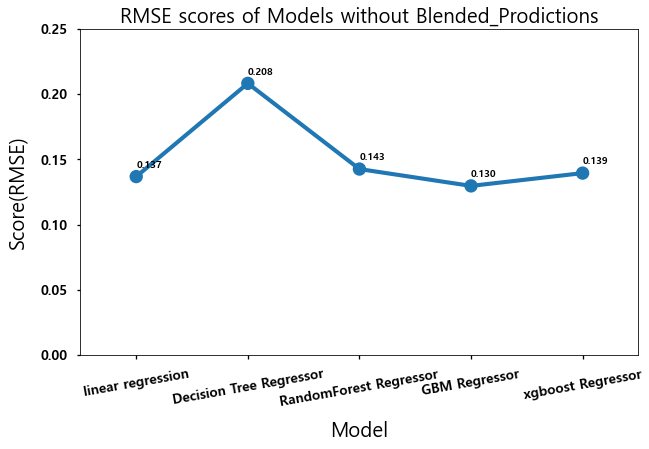

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.pointplot(x=list(rmse_scores.keys()), y=[score for score, _ in rmse_scores.values()],
                  markers=['o'], linestyles=['-'], ax=ax)

for i, score in enumerate(rmse_scores.values()):
    ax.text(i, score[0]+0.007, '{:.3f}'.format(score[0]))
    
ax.set_ylabel('Score(RMSE)', size=20, labelpad=12.5)
ax.set_xlabel('Model', size=20, labelpad=12.5)
ax.tick_params(axis='x', labelsize=13.5, rotation=10)
ax.tick_params(axis='y', labelsize=13.5)
ax.set_ylim(0,0.25)
ax.set_title('RMSE scores of Models without Blended_Prodictions', size=20)


In [ ]:
for i, score in enumerate(rmse_scores.values()):
#     ax.text(i, score[0]+0.002, '{:.6f}'.format(score[0]),
#             horizontalalignment = 'left', size='large',
#             color='black', weight = 'wemibold')

    print(i)
    print(type(score[0]))

0
<class 'numpy.float64'>
1
<class 'numpy.float64'>
2
<class 'numpy.float64'>
3
<class 'numpy.float64'>
4
<class 'numpy.float64'>


In [ ]:
X = all_df.iloc[:len(y), :]
X_test2 = all_df.iloc[len(y):, :]
X.shape, y.shape, X_test2.shape

gbr_model_fit = gbr_model.fit(X,y)
final_preds = np.floor(np.expm1(gbr_model_fit.predict(X_test2)))
print(final_preds)

[120123. 152436. 181386. ... 158716. 119718. 246015.]


In [ ]:
submission.iloc[:,1] = final_preds

submission.to_csv('The_first_regression.csv', index=False)

In [ ]:
gbr_model.score(X,y)

0.9564624741159721